# Determining the difference between sampled data within similar time ranges

## Goal of project: 
-  Find all of the different ways to compare time series. 
-  Quantify the similarity or dis-similarity of two (or more) time series.

In [70]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

import math

import statistics
from scipy import stats

from scipy.fftpack import fft, ifft

from scipy import interpolate

### A few select curves to compare

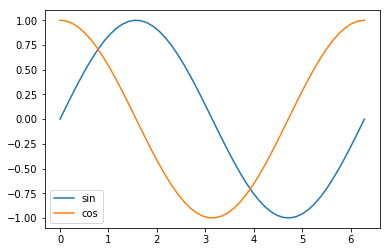

In [71]:
# Comparing sin and cos
x = np.linspace(0, 2 * np.pi)
sin = np.sin(x)
cos = np.cos(x)

fig, ax = plt.subplots()
ax.plot(x, sin, label="sin")
ax.plot(x, cos, label="cos")
ax.legend()
plt.show()

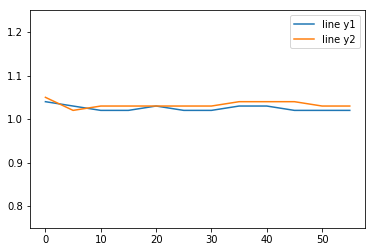

In [72]:
# Comparing two approximately flat lines
line_x = np.array([0,5,10,15,20,25,30,35,40,45,50,55])
line_y1 = np.array([1.04,1.03,1.02,1.02,1.03,1.02,1.02,1.03,1.03,1.02,1.02,1.02])
line_y2 = np.array([1.05,1.02,1.03,1.03,1.03,1.03,1.03,1.04,1.04,1.04,1.03,1.03])

fig, ax = plt.subplots()
ax.plot(line_x, line_y1, label="line y1")
ax.plot(line_x, line_y2, label="line y2")
plt.ylim(top=1.25, bottom=0.75) 
ax.legend()
plt.show()

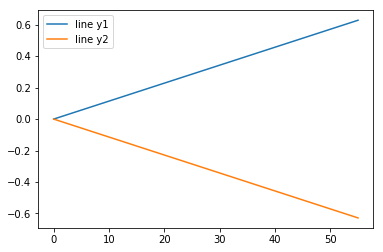

In [73]:
# Comparing two flat lines
linear_x = np.linspace(0, 55)
linear_y1 = x * 0.1
linear_y2 = x * - 0.1

fig, ax = plt.subplots()
ax.plot(linear_x, linear_y1, label="line y1")
ax.plot(linear_x, linear_y2, label="line y2")
ax.legend()
plt.show()

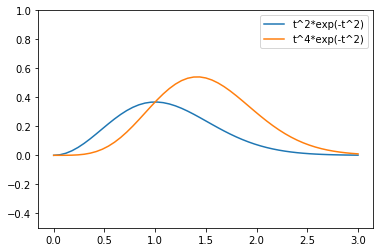

In [74]:
# Comparing two similar curves that are concave down
def f1(t):
    return t**2*np.exp(-t**2)

def f2(t):
    return t**2*f1(t)

t = np.linspace(0, 3, 51) # 51 points between 0 and 3
y1 = f1(t) 
y2 = f2(t) 

fig, ax = plt.subplots()
ax.plot(t, y1, label='t^2*exp(-t^2)')
ax.plot(t, y2, label='t^4*exp(-t^2)')
# plt.ylim(top=-0.5, bottom=0.7) 
plt.ylim(top=1, bottom=-.5) 
ax.legend()
plt.show()

## Diffing areas (integrals)

In [75]:
# Comparing sin and cos integrals
sin_int = integrate.trapz(sin, x)
cos_int = integrate.trapz(cos, x)

print (sin_int - cos_int)

7.806255641895632e-17


In [76]:
# Comparing ~flat lines

In [77]:
# Comparing concave down

## Diffing ~straight-lines (statistics)

**Compute statistics for two sets of measurements:**

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html

slope : slope of the regression line

intercept : intercept of the regression line

r-value : correlation coefficient

p-value : two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero

stderr : Standard error of the estimate

The closer that the absolute value of the correlation coefficient (r value) is to one, the better the data are described by a linear equation. 
The dataset is perfectly aligned if r = 1 or r = -1. Datasets with r values close to zero show little 
to no straight-line relationship.

    r > 0.99 - curves are virtually identical

    r > 0.95 - very high similarity

    0.67 < r < 0.95 - high similarity

    0.33 < r < 0.67 - some (moderate) similarity

    0.05 < r < 0.33 - not very similar

    r < 0.05 - no similarity at all

Note that when using pandas, to compute the correlation coefficient, see: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

In [78]:
# Comparing sin and cos
slope, intercept, r_value, p_value, std_err = stats.linregress(sin, cos)
print ('Sin vs cos:', '\nr value:', r_value, '\np-value:', p_value) # As expected, these curves are not linear, and thus show r values close to zero

Sin vs cos: 
r value: 6.665285165231957e-18 
p-value: 1.0


In [79]:
# Comparing ~flat lines
slope, intercept, r_value, p_value, std_err = stats.linregress(line_y1, line_y2)
print ('Straight lines:', '\nr value:', r_value, '\np-value:', p_value)

Straight lines: 
r value: 0.5196152422706631 
p-value: 0.08336922304872832


In [80]:
# Comparing concave down
slope, intercept, r_value, p_value, std_err = stats.linregress(y1, y2)
print ('Concave down:', '\nr value:', r_value, '\np-value:', p_value)

Concave down: 
r value: 0.6543054162699397 
p-value: 1.9149678083855617e-07


In [81]:
# Comparing straight lines that have different slopes
slope, intercept, r_value, p_value, std_err = stats.linregress(linear_y1, linear_y2)
print ('Straight lines with different slopes:', '\nr value:', r_value, '\np-value:', p_value)

Straight lines with different slopes: 
r value: -1.0 
p-value: 0.0


## Goodness-of-fit tests

### *Kolmogorov-Smirnov test*
https://projecteuclid.org/download/pdf_1/euclid.aoms/1177706788

https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm

The Kolmogorov-Smirnov test can be used to determine if two datasets differ significantly. There are two Kolmogorov-Smirnov tests:
-  The *one sample Kolmogorov-Smirnov test* is for testing if a variable follows a given distribution within a population. This given distribution is usually, but not always, the normal distribution, and is sometimes called the “Kolmogorov-Smirnov normality test”
-  The *independent samples Kolmogorov-Smirnov test* is for testing if a variable has identical distributions in two populations.

Note that the k-s test shown in the code below returns the D statistic (KS statistic) and a p-value corresponding to the D. 

P-values report if the numbers differ significantly. When discussing a p-value, we are referring to the area under the curve of a distribution. The p-value is a number between 0 and 1 and interpreted in the following way:

    p-value ≤ 0.05 - indicates strong evidence against the null hypothesis. So, reject the null hypothesis

    p-value > 0.05 - indicates weak evidence against the null hypothesis. Do not reject the null hypothesis

    p-values very close to 0.05 are considered to be marginal (they could go either way)

The D is the absolute max distance between the cumulative distribution function's of the two samples. The closer the D is to zero, the more likely it is that the two samples were drawn from the same distribution.  

In [82]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples, use: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html
# Note that the test uses the two-sided asymptotic Kolmogorov-Smirnov distribution

KS_sin_cos = stats.ks_2samp(sin, cos)
KS_straight = stats.ks_2samp(line_y1, line_y2)
KS_conc_down = stats.ks_2samp(y1, y2)
print ('Sin vs cos: ', '\nD statistic:', KS_sin_cos[0], '\nP-value:', KS_sin_cos[1])
print ('\nStraight lines: ', '\nD statistic:', KS_straight[0], '\nP-value:', KS_straight[1])
print ('\nConcave down: ', '\nD statistic:', KS_conc_down[0], '\nP-value:', KS_conc_down[1])


Sin vs cos:  
D statistic: 0.040000000000000036 
P-value: 0.9999999999973649

Straight lines:  
D statistic: 0.5 
P-value: 0.06558396391880224

Concave down:  
D statistic: 0.2941176470588235 
P-value: 0.018876511788664445


The sin and cos curves have a p-value near 1, which indicates that they _________ 

### *Chi-Square Test*

### *Cramer Von-Mises test*

### *Anderson-Darling test*
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm

## Normal (Gaussian) distribution

### *T-test*
This is a test for the null hypothesis that 2 independent samples both have identical average (expected) values. This test also assumes that the populations have identical variances. It measures whether the average (expected) value differs significantly across two samples. 
Please see: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_ind.html

In [83]:
stats.ttest_ind(sin, cos, axis=0, equal_var=True)
# stats.ttest_ind(sin, cos, axis=0, equal_var=False)

Ttest_indResult(statistic=-0.14002800840280044, pvalue=0.8889252534042843)

## Fourier transform 
Fourier analysis can be used to express a function as a sum of periodic components, and to recover the function from those components. Implementation details can be found here: https://docs.scipy.org/doc/numpy/reference/routines.fft.html

In [84]:
# Compute Fourier Transform using: https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html
fourier_sin = fft(sin, n=None, axis=-1, overwrite_x=False)
fourier_cos = fft(cos, n=None, axis=-1, overwrite_x=False)

# A boolean array where two arrays are element-wise equal within a tolerance
print ('Sin vs cos:', np.isclose(fourier_sin, fourier_cos, rtol=1e-05, atol=1e-08, equal_nan=False))
# Returns True if two arrays are element-wise equal within a tolerance
# print (np.allclose(fft(sin), fft(cos), atol=1e-15))

fourier_line_y1 = fft(line_y1, n=None, axis=-1, overwrite_x=False)
fourier_line_y2 = fft(line_y2, n=None, axis=-1, overwrite_x=False)
print ('\nStraight lines:', np.isclose(fourier_line_y1, fourier_line_y2, rtol=1e-05, atol=1e-08, equal_nan=False))
# print (np.allclose(fft(fourier_line_y1), fft(fourier_line_y2), atol=.04))
print ('\nFourier transform line_y1: ', fourier_line_y1)

Sin vs cos: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]

Straight lines: [False False False False False False  True False False False False False]

Fourier transform line_y1:  [1.23000000e+01+0.00000000e+00j 1.00000000e-02-1.11022302e-16j
 2.00000000e-02-1.73205081e-02j 4.00000000e-02-4.44089210e-16j
 1.12757026e-16-1.73205081e-02j 1.00000000e-02-1.11022302e-16j
 2.00000000e-02+0.00000000e+00j 1.00000000e-02+1.11022302e-16j
 1.12757026e-16+1.73205081e-02j 4.00000000e-02+4.44089210e-16j
 2.00000000e-02+1.73205081e-02j 1.00000000e-02+1.11022302e-16j]


## Piecewise pointwise

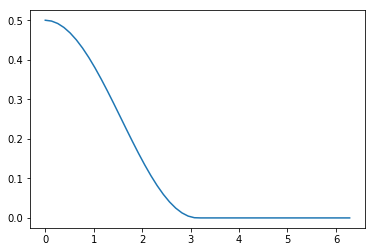

In [85]:
piecew = np.piecewise(x,[x<=math.pi],[lambda x:(np.cos(x)+1)/4.0])
plt.plot(x, piecew)
plt.show()

In [86]:
def compare_curves_f(values_1, values_2, title):
    """
    Return two y-axis arrays and one x-axis array.
    """
    pass

Minimum vertical distance between the curves:  0.012982682466595175
Maximum vertical distance between the curves:  0.29886246312412523
Mean of the vertical distance between the curves:  0.12049099881737295
area:  0.3451239095968639
area2:  0.05658325071568715


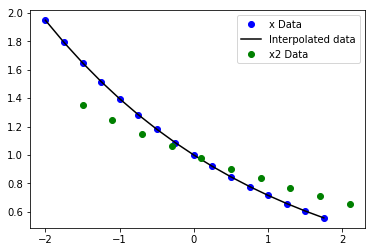

derivatives:  [-0.62292886 -0.59802554 -0.55021006 -0.50621769 -0.46574276 -0.42850402
 -0.39424273 -0.36272083 -0.33371927 -0.30703655 -0.28248726 -0.25990083
 -0.23912031 -0.2200013  -0.20241097 -0.19398206]


In [87]:
x_values = np.arange(-2, 2, 0.25)
y_values = np.exp(-x_values/3.0)
x2_values = np.arange(-1.5, 2.5, 0.4)
y2_values = np.exp(-x2_values/5.0)

# Find the x- values that overlap
x_values_min = min(x_values)
x_values_max = max(x_values)
x2_values_min = min(x2_values)
x2_values_max =  max(x2_values)
x_range_min = max(x_values_min, x2_values_min)
x_range_max = min(x_values_max, x2_values_max)
 
# Create a grid where we have a point at each integer value between -2 and 2 in the x directions
#xx, yy = np.meshgrid(x_values, y_values)
#plt.plot(xx, yy, marker='.', color='k', linestyle='none')

# Interpolate the master curve
f = interpolate.interp1d(x_values, y_values, kind='cubic')

ynew = f(x_values)   # Use interpolation function returned by 'interp1d'

x2_overlap_values = np.arange(x_range_min, x_range_max, 0.4) # X values that overlap, these are the overlap points with a designated step of 0.4 (similar to the step in x2_values)
y_values_interp = f(x2_overlap_values) # This provides the y values of the black line (interpolated line) at the x values that are the green circles

y2_overlap_values = np.exp(-np.arange(x_range_min, x_range_max, 0.4)/5.0)

# Max, min, and mean between the curves
y_distance = np.absolute(y_values_interp - y2_overlap_values) # Distance (element-wise) from the points on the (green dot) curve to the interpolated (master) curve along the y-axis
print ('Minimum vertical distance between the curves: ', min(y_distance))
print ('Maximum vertical distance between the curves: ', max(y_distance))
print ('Mean of the vertical distance between the curves: ', np.mean(y_distance))

# Area between the curves
curves_area = np.trapz(y_distance, x2_overlap_values)
print ('area: ', curves_area)

# ***** I think this is the correct area between the curves - look into this further *****
curves_int1 = integrate.trapz(y_values_interp, x2_overlap_values)
curves_int2 = integrate.trapz(y2_overlap_values, x2_overlap_values)
int = curves_int1 - curves_int2
print ('area2: ', int)

'''
curves_int1 = integrate.simps(y_values_interp, x2_overlap_values)
curves_int2 = integrate.simps(y2_overlap_values, x2_overlap_values)
int = curves_int1 - curves_int2
print (int)
'''
# Decide which integration calculation method to use, see e.g.: https://stackoverflow.com/questions/44915116/how-to-decide-between-scipy-integrate-simps-or-numpy-trapz
# Also see: https://stackoverflow.com/questions/25439243/find-the-area-between-two-curves-plotted-in-matplotlib-fill-between-area

# Plot the curves
plt.plot(x_values, y_values, 'bo', label='x Data')
plt.plot(x_values, ynew, 'k-', label='Interpolated data')
plt.plot(x2_values, y2_values, 'go', label='x2 Data')
plt.legend(loc='upper right')
plt.show()

# Get a normal to the curve, steps: see https://www.khanacademy.org/math/multivariable-calculus/integrating-multivariable-functions/line-integrals-in-vector-fields-articles/a/constructing-a-unit-normal-vector-to-curve
# 1) Parameterize the curve, make sure that it is given parametrically
# 2) Find a tangent vector, take the derivative at each point along the curve, which would be the tangent vector
# 3) Rotate the tangent vector by 90 degrees, in other words, swap the two components and make one of them negative.  If you are rotating counterclockwise, make the first component negative; if you are rotating clockwise, make the second component negative. 

# Getting the tangent for each (blue) point along the interpolated curve 
dydx = np.gradient(y_values, x_values) # the derivative of y with respect to x
#  Note: if dx isn't constant, then interpolate y with a constant dx, then calculate the gradient as above
print ('derivatives: ', dydx) # Derivatives of the function (i.e., the interpolated curve)
# print ('The first x-axis value is: ', x_values[0])
# print ('The derivative at x=-2 is: ', dydx[0]) # Numerically find the derivative at x = -2 



In [88]:
def compare_curves(values_x1, values_y1, values_x2, values_y2):
    """
    Parameters:
    values_y1: input array of y values from sampled data for the (interpolated) master curve
    values_x1: input x values of sampled data
    values_y2: input a second y values of sampled data
    values_x2: input a second x values of sampled data
    
    NOTE: the x1 and y1 values must have the same shape. The
    x2 and y2 values must have the same shape.
    
    Return the minimum, maximum, and mean vertical distances between two curves.
    Return the area between two curves.
    A plot of the curves is provided.
    """

    # Determine the overlapping x- values 
    x_values_min = min(values_x1)
    x_values_max = max(values_x1)
    x2_values_min = min(values_x2)
    x2_values_max =  max(values_x2)
    x_range_min = max(x_values_min, x2_values_min)
    x_range_max = min(x_values_max, x2_values_max)
    
    x1_overlapping = values_x1[values_x1 >= x_range_min & values_x1 <= x_range_max]

    # Interpolate the master curve
    f = interpolate.interp1d(values_x1, values_y1, kind='cubic')
    f1 = interpolate.interp1d(values_x2, values_y2, kind='cubic')
    
    # Use interpolation function returned by 'interp1d'
    ynew = f(values_x1)   

    x2_overlap_values = np.arange(x_range_min, x_range_max, 0.4) # X values that overlap, these are the overlap points with a designated step of 0.4 (similar to the step designated in values_x2)
    y_values_interp = f(x2_overlap_values) # This provides the y values of the black line (interpolated line) at the position of the x values that are the green circles on the curve below it

    #y2_overlap_values = np.exp(-np.arange(x_range_min, x_range_max, 0.4)/5.0)
    #print (values_y2(x2_overlap_values))

    # Compute the max, min, and mean between two curves
    y_distance = np.absolute(y_values_interp - y2_overlap_values) # Distance (element-wise) from the points on the (green dot) curve to the interpolated (master) curve along the y-axis
    print ('y distances: ', y_distance)
    print ('Minimum distance between curves: ', min(y_distance))
    print ('Maximum distance between curves: ', max(y_distance))
    print ('Mean of the distance between curves: ', np.mean(y_distance))
    
    # Determine the index of both the min and max distances between two curves are within y_distance
    y_min = min(y_distance)
    y_max = max(y_distance)
    y_dist_index_list = [0]
    index = 0
    for i in y_distance:
        index = index + 1
        y_dist_index_list.append(index)
        if i == y_min:
            y_dist_index_min = index - 1 # Index of where the minimum distance between the curves is located within y_distance
        elif i == y_max:
            y_dist_index_max = index - 1 # Index of where the maximum distance between the curves is located within y_distance
    print (y_dist_index_max)
    print ('y2 overlap values: ', y2_overlap_values)
    
    # Integrate each curve and subtract one from the other 
    curves_int1 = integrate.trapz(y_values_interp, x2_overlap_values)
    curves_int2 = integrate.trapz(y2_overlap_values, x2_overlap_values)
    integrated_diff = curves_int1 - curves_int2
    print ('Area: ', integrated_diff)

    # Plot the curves
    plt.plot(values_x1, values_y1, 'bo', label='x1 Data')
    plt.plot(values_x1, ynew, 'k-', label='Interpolated data')
    plt.plot(values_x2, values_y2, 'go', label='x2 Data')
    # plt.plot(values_x2, f1(values_x2), 'g-', label='Interpolated x2 Data') # Interpolate curve beneath the master curve, for visualization only 
    plt.legend(loc='upper right')
    plt.show()

x_values = np.arange(-2, 2, 0.25)
y_values = np.exp(-x_values/3.0)
x2_values = np.arange(-1.5, 2.5, 0.4)
y2_values = np.exp(-x2_values/5.0) # np.exp(-np.arange(x_range_min, x_range_max, 0.4)/5.0)
compare_curves(x_values, y_values, x2_values, y2_values)

x = np.linspace(0, 2 * np.pi)
sin = np.sin(x)
cos = np.cos(x)

x_values = np.linspace(0, 2 * np.pi)
sin_values = np.sin(x_values)
x2_values = np.arange(-1.5, 2.5, 0.4)
cos_values = np.cos(x2_values)
compare_curves(x_values, sin_values, x2_values, cos_values)


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# find the minimum distance from a point to a curve
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla

# Designate a point 'P'
point = (0.5, 2)

# Define a function
def f(x):
    return np.exp(-x**2/3.0)

def distance(X):
    x,y = X
    return np.sqrt((x - point[0])**2 + (y - point[1])**2) # Distance formula 


def c1(X):
    x,y = X
    return f(x) - y


X = fmin_cobyla(distance, x0=[0.5,0.5], cons=[c1])

print ('The minimum distance is {0:1.2f}'.format(distance(X)))

# Verify the vector to this point is normal to the tangent of the curve
# position vector from curve to point
v1 = np.array(point) - np.array(X)
# position vector
v2 = np.array([1, 2.0 * X[0]])
print ('dot(v1, v2) = ',np.dot(v1, v2))

x = np.linspace(-2, 2, 100)

plt.plot(x, f(x), 'r-', label='f(x)')
plt.plot(point[0], point[1], 'bo', label='point')
plt.plot([point[0], X[0]], [point[1], X[1]], 'b-', label='shortest distance')
#plt.plot([X[0], X[0] + 1], [X[1], X[1] + 2.0 * X[0]], 'g-', label='tangent')
plt.axis('equal')
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend(loc='best')
plt.show()

diff overlap:  [0.3640468  0.30567165 0.25332053 0.20776839 0.16901603 0.13658213
 0.10977585]
ys1 values within overlap range:  [0.24252107 0.16668213 0.11455884 0.07873507 0.05411377 0.03719181
 0.02556153]
ys2 values within overlap range:  [0.60656788 0.47235378 0.36787938 0.28650346 0.22312979 0.17377394
 0.13533738]
Minimum distance between curves:  0.10977585090529797
Maximum distance between curves:  0.3640468049278144
Mean distance between curves:  0.2208830546246381
Area between curves:  -1.636587568069888


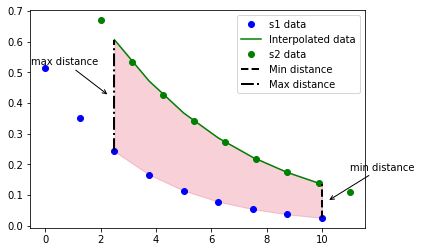

'\nx_values = np.linspace(0, 2 * np.pi)\nsin_values = np.sin(x_values)\nx2_values = np.arange(-1.5, 2.5, 0.4)\ncos_values = np.cos(x2_values)\ncompare_curves_v2(x_values, sin_values, x2_values, cos_values)\n'

In [106]:
def compare_curves_v2(xs1, ys1, xs2, ys2):
    """
    Parameters:
    xs1: input array of x values from sampled data 
    ys1: input array of y values of sampled data
    xs2: input a second array of x values of sampled data
    ys2: input a second array of y values of sampled data
    
    NOTE: the x1 and y1 values must have the same shape. And the
    x2 and y2 values must have the same shape.
    
    Return the minimum, maximum, and mean vertical distances between two curves.
    Return the area between two curves.
    A plot of the curves is provided with the area shaded.
    """

    # Determine the overlapping x- values 
    xs1_min = min(xs1)
    xs1_max = max(xs1)
    xs2_min = min(xs2)
    xs2_max =  max(xs2)
    xs_overlap_min = max(xs1_min, xs2_min)
    xs_overlap_max = min(xs1_max, xs2_max)
    # print (f"Overlapping x: [{xs_overlap_min}, {xs_overlap_max}]") # The min and max overlap values, provides two overall values for the min and max overlap range between the two curves
    
    xs1_overlap_where = np.where((xs1 >= xs_overlap_min) & (xs1 <= xs_overlap_max)) # x values >= the min of both curves and x values <= the max of both curves
    xs1_overlap = xs1[xs1_overlap_where] # xs1 overlap values, these are the points along the xs1 curve within the overlap range
    
    # Interpolate master curve
    f2 = interpolate.interp1d(xs2, ys2, kind='cubic')
    ys2_interp_overlap = f2(xs1_overlap) # y values of the interpolated line at the points of xs1_overlap range
    
    # Compute vertical difference in y values between the y values of ys1 within the xs1 overlap range and the y values of the interpolated line at the ys1 points of xs1 overlap range
    diff_overlap = abs(ys1[xs1_overlap_where] - ys2_interp_overlap) # y values of ys1 within the overlap range minus the y values of the interpolated line at the ys1 points of overlap range
    print ('diff overlap: ', diff_overlap)
    print ('ys1 values within overlap range: ', ys1[xs1_overlap_where])
    print ('ys2 values within overlap range: ', ys2_interp_overlap)
    
    # Compute Euclidean distance between the above two curves (same as above vertical difference calculation because the x-values here are the same now)
    Euc_dist = np.sqrt((xs1_overlap - xs1_overlap)**2 + (ys1[xs1_overlap_where] - ys2_interp_overlap)**2) 
    
    # Compute min, max, mean values between curves
    diff_overlap_min = min(diff_overlap)
    diff_overlap_max = max(diff_overlap)
    print ('Minimum distance between curves: ', diff_overlap_min)
    print ('Maximum distance between curves: ', diff_overlap_max)
    print ('Mean distance between curves: ', np.mean(diff_overlap))
    
    # Determine the index of both the min and max distances between two curves are within y_distance
    y_min = min(diff_overlap)
    y_max = max(diff_overlap)
    y_diff_overlap_index = [0]
    index = 0
    for i in diff_overlap:
        index = index + 1
        y_diff_overlap_index.append(index)
        if i == y_min:
            y_dist_index_min = index - 1 # Index of where the minimum distance between the curves is located within y_distance
        elif i == y_max:
            y_dist_index_max = index - 1 # Index of where the maximum distance between the curves is located within y_distance
    
    x_value_min = []
    x_value_max = []
    for i in range(2):    
        x_value_min.append(xs1_overlap[y_dist_index_min]) # x value where the minimum between the two curves is located, appending it twice in order to plot the min location between curves
        x_value_max.append(xs1_overlap[y_dist_index_max]) # x value where the maximum between the two curves is located, appending it twice in order to plot the max location between curves
    
    # Get endpoints at minimum and maximum distances between curves, to annotate plot
    diff_overlap_min_y = [] # Two y-axis end points where the minimum between the two curves is located
    diff_overlap_min_y.append(ys1[xs1_overlap_where][y_dist_index_min])
    diff_overlap_min_y.append(ys2_interp_overlap[y_dist_index_min])
    diff_overlap_min_y_middle = ((ys1[xs1_overlap_where][y_dist_index_min]) + (ys2_interp_overlap[y_dist_index_min]))/2 # Location of where to annotate an arrow along the y-axis
    diff_overlap_max_y = [] # Two y-axis end points where the maximum between the two curves is located
    diff_overlap_max_y.append(ys1[xs1_overlap_where][y_dist_index_max])
    diff_overlap_max_y.append(ys2_interp_overlap[y_dist_index_max])
    diff_overlap_max_y_middle = ((ys1[xs1_overlap_where][y_dist_index_max]) + (ys2_interp_overlap[y_dist_index_max]))/2 # Location of where to annotate an arrow along the y-axis
    
    # Compute the area in between the curves 
    curves_int1 = integrate.trapz(ys1[xs1_overlap_where], xs1_overlap)
    curves_int2 = integrate.trapz(ys2_interp_overlap, xs1_overlap)
    integrated_diff = curves_int1 - curves_int2
    print ('Area between curves: ', integrated_diff)
    
    plt.plot(xs1, ys1, 'bo', label='s1 data')
    plt.plot(xs1_overlap, ys2_interp_overlap, 'g-', label='Interpolated data')
    plt.plot(xs2, ys2, 'go', label='s2 data')
    plt.plot(x_value_min, diff_overlap_min_y, 'k--', linewidth=2, label='Min distance')
    plt.plot(x_value_max, diff_overlap_max_y, 'k-.', linewidth=2, label='Max distance')
    plt.legend(loc='best')
    plt.annotate('min distance', xy=((x_value_min[0]+.2), (diff_overlap_min_y_middle)), xytext=((x_value_min[0] + 1), (diff_overlap_min_y_middle+.1)),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.annotate('max distance', xy=((x_value_max[0]-.2), (diff_overlap_max_y_middle)), xytext=((x_value_max[0] - 3), (diff_overlap_max_y_middle+.1)),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    plt.fill_between(xs1_overlap, (ys2_interp_overlap), ys1[xs1_overlap_where], color="crimson", alpha=0.2) # The area is shaded between the curves
    plt.show()
    

'''
xs1 = np.linspace(0, 10, 7)
xs2 = np.linspace(2, 11, 9)
ys1 = np.ones_like(xs1)
ys2 = np.exp(-xs2/5.0)
compare_curves_v2(xs1, ys1, xs2, ys2)
'''

xs1 = np.linspace(0, 10, 9)
xs2 = np.linspace(2, 11, 9)
ys1 = np.exp(-xs2/3.0)
ys2 = np.exp(-xs2/5.0)
compare_curves_v2(xs1, ys1, xs2, ys2)

'''
x_values = np.linspace(0, 2 * np.pi)
sin_values = np.sin(x_values)
x2_values = np.arange(-1.5, 2.5, 0.4)
cos_values = np.cos(x2_values)
compare_curves_v2(x_values, sin_values, x2_values, cos_values)
'''
###### To do: Make the longer curve between both curves, within the overlap range, the interpolated master curve???